### `import` Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification

### Data Preparation

In [2]:
# X, y = make_blobs(
#     n_samples=500, 
#     n_features=2, 
#     centers=2, 
#     random_state=60
# )

X, y = make_classification(
    n_samples=500, 
    n_features=2, 
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=2,
    random_state=60
)

In [3]:
def standardize_data_features(data, in_numpy=False):
    data_copy = data.copy()
    
    for col in data_copy.columns:
        mean_val = np.mean(data_copy[col])
        std_dev_val = np.std(data_copy[col])
        data_copy[col] = [(dval - mean_val)/std_dev_val for dval in data_copy[col]]
    
    if not in_numpy:
        return data_copy
    return data_copy.to_numpy()

In [4]:
d = {'col{}'.format(i + 1) : X[:,i] for i in range(len(X[0]))}
df = pd.DataFrame(d)
df = standardize_data_features(data=df)
df['label'] = y

In [5]:
df.head()

,col1,col2,label
0,-1.190067,1.918338,0
1,-0.894067,0.339529,1
2,-0.196368,-1.134401,1
3,-1.079944,0.911645,1
4,0.136143,0.844458,0


### Train Test Split

In [6]:
def splitter(dframe, percentage=0.8, random_state=True):
    """
    :param DataFrame dframe: Pandas DataFrame
    :param float percentage: Percentage value to split the data
    :param boolean random_state: True/False
    :return: train_df, test_df
    """
    if random_state:
        dframe = dframe.sample(frac=1)

    thresh = round(len(dframe) * percentage)
    train_df = dframe.iloc[:thresh]
    test_df = dframe.iloc[thresh:]

    return train_df, test_df

In [7]:
train_df, test_df = splitter(dframe=df)

### Custom Logistic Regression

In [8]:
class LogisticRegression():
    def __init__(self, train_df, test_df, label, lambda_=0.0001, n_iters=1000):
        self.lambda_ = lambda_
        self.n_iters = n_iters
        
        self.X_train, self.y_train = self.split_features_targets(df=train_df, label=label)
        self.X_test, self.y_test = self.split_features_targets(df=test_df, label=label)
        self.X_train = self.X_train.values
        self.y_train = self.y_train.values
        self.X_test = self.X_test.values
        self.y_test = self.y_test.values
        self.n_ = len(self.X_train)
        
        self.w, self.b = self.find_best_params()
    
    def split_features_targets(self, df, label):
        X = df.drop(columns=[label], axis=1)
        y = df[label]
        return X, y
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def diff_params_wb(self, w, b):
        lm = np.dot(self.X_train, w) + b
        z = self.sigmoid(z=lm)
        w_ = (1 / self.n_) * np.dot((z - self.y_train), self.X_train)
        b_ = (1 / self.n_) * np.sum((z - self.y_train))
        return w_, b_
    
    def find_best_params(self):
        ow = np.zeros_like(a=self.X_train[0])
        ob = 0
        
        for i in range(self.n_iters):
            w_, b_ = self.diff_params_wb(w=ow, b=ob)
            ow = ow - (self.lambda_ * w_)
            ob = ob - (self.lambda_ * b_)
        
        return ow, ob
    
    def draw_line(self, ax):
        if (len(self.w) == 2):
            a, b = self.w
            c = self.b

            y_min = np.min(self.X_train)
            y_max = np.max(self.X_train)

            p1 = [((-b*y_min - c)/a), y_min]
            p2 = [((-b*y_max - c)/a), y_max]

            points = np.array([p1, p2])
            ax.plot(points[:, 0], points[:, 1], color='#BA4A00')
        return None
    
    def predict(self, with_plot=False):        
        y_test_preds = self.sigmoid(z=(np.dot(self.X_test, self.w) + self.b))
        y_test_preds_c = np.where((y_test_preds >= 0.5), 1, 0)
        y_train_preds = self.sigmoid(z=(np.dot(self.X_train, self.w) + self.b))
        y_train_preds_c = np.where((y_train_preds >= 0.5), 1, 0)
        
        if with_plot:
            fig = plt.figure(figsize=(10, 4))

            ax1 = fig.add_subplot(1, 2, 1)
            ax1.title.set_text('Training')
            ax1.scatter(self.X_train[:, 0], self.X_train[:, 1], c=y_train_preds_c, label='points')
            self.draw_line(ax=ax1)
            ax1.legend()
            
            ax2 = fig.add_subplot(1, 2, 2)
            ax2.title.set_text("Testing")
            ax2.scatter(self.X_test[:, 0], self.X_test[:, 1], c=y_test_preds_c, label='points')
            self.draw_line(ax=ax2)
            ax2.legend()
            
            plt.show()
        return y_test_preds_c
    
    def score(self, preds):
        preds = np.array(preds)
        if (len(self.y_test) == len(preds)):
            non_z = np.count_nonzero(a=np.where((preds == self.y_test), 1, 0))
            return non_z / len(preds)
        return "Lengths do not match"

### Testing

In [9]:
lr = LogisticRegression(
    train_df=train_df, 
    test_df=test_df, 
    label='label', 
    lambda_=0.001, 
    n_iters=100
)

In [14]:
print(lr.w)

[-3.77376685e-02 -5.56964363e-06]


In [11]:
lr.b

0.0017126093242175264

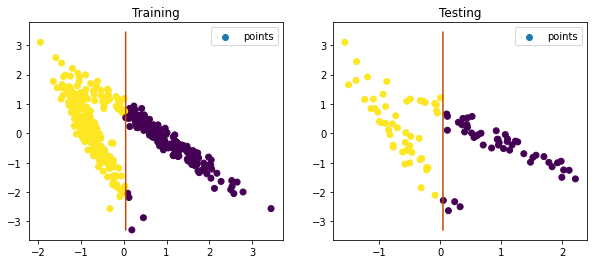

In [12]:
preds = lr.predict(with_plot=True)

In [13]:
lr.score(preds=preds)

0.84

### End